In [8]:
"""
Gather event- and daily-level FIRED polygons for western U.S. ecoregions
Author: maxwell.cook@colorado.edu
"""

import os, time, glob, gc
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import warnings
warnings.filterwarnings("ignore")
                        
proj = 'EPSG:5070'

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')

print("Ready !")

Ready !


In [6]:
# Load the event FIRED polygons
fp = os.path.join(maindir,'FIRED/data/spatial/mod/events/fired-events_conus_ak_2000_to_2024_lambert.gpkg')
events = gpd.read_file(fp)
events = events[(events['ig_year'] >= 2012) & (events['ig_year'] <= 2023)] # work with 2012-> VIIRS
events = events.to_crs(proj) # project to EPSG:5070

# Load western U.S. ecoregions
fp = os.path.join(projdir,'data/spatial/mod/boundaries/na_cec_eco_l3_west.gpkg')
ecol3 = gpd.read_file(fp)
ecol3 = ecol3[['NA_L3NAME','geometry']]
ecol3 = ecol3.rename(columns={'NA_L3NAME': 'na_l3name'})

# Extract within western U.S. ecoregions (CONUS)
assert events.crs == ecol3.crs, "CRS mismatch, fix it !"
events_west = gpd.sjoin(events, ecol3, how='inner', predicate='within')
events_west.drop('index_right', axis=1, inplace=True)
    
print(f"There are {len(events_west)} unique fire events across western U.S. ecoregions in CONUS (2012-2023).")
print(f"Data columns:\n{events_west.columns}")

# Handle the date fields before exporting
date_cols = ['ig_date', 'last_date', 'mx_grw_dte']
for col in date_cols:
    events_west[col] = pd.to_datetime(events_west[col], errors='coerce')

# Save the file.
events_west.to_file(os.path.join(projdir, 'data/spatial/raw/FIRED/fired-events_west_2012_to_2023.gpkg'))

del events, ecol3
gc.collect() # clean up

There are 18529 unique fire events across western U.S. ecoregions in CONUS (2012-2023).
Data columns:
Index(['id', 'ig_date', 'ig_day', 'ig_month', 'ig_year', 'last_date',
       'event_dur', 'tot_pix', 'tot_ar_km2', 'fsr_px_dy', 'fsr_km2_dy',
       'mx_grw_px', 'mn_grw_px', 'mu_grw_px', 'mx_grw_km2', 'mn_grw_km2',
       'mu_grw_km2', 'mx_grw_dte', 'x', 'y', 'ig_utm_x', 'ig_utm_y', 'lc_code',
       'lc_mode', 'lc_name', 'lc_desc', 'lc_type', 'eco_mode', 'eco_name',
       'eco_type', 'tot_perim', 'geometry', 'na_l3name'],
      dtype='object')


0

In [9]:
fired_ids_west = set(events_west['id']) # unique fire ids
print(len(fired_ids_west))

# Extract the daily events from the western U.S. subset
fp = os.path.join(maindir,'FIRED/data/spatial/mod/events/fired-daily_conus_ak_2000_to_2024_lambert.gpkg')
daily = gpd.read_file(fp)
daily_west = daily[daily['id'].isin(fired_ids_west)]
print(f"There are [{len(daily_west)}] unique daily perimeters for western U.S. FIRED (2012-2023).")
print(f"Data columns:\n{daily_west.columns}")    

# Handle the date fields before exporting
date_cols = ['date', 'ig_date', 'last_date', 'mx_grw_dte']
for col in date_cols:
    events_west[col] = pd.to_datetime(events_west[col], errors='coerce')

# Save the file.
daily_west.to_file(os.path.join(projdir, 'data/spatial/raw/FIRED/fired-daily_west_2012_to_2023.gpkg'))

del daily
gc.collect() # clean up 

18529
There are [63264] unique daily perimeters for western U.S. FIRED (2012-2023).
Data columns:
Index(['did', 'id', 'date', 'ig_date', 'ig_day', 'ig_month', 'ig_year',
       'last_date', 'event_day', 'event_dur', 'pixels', 'tot_pix', 'dy_ar_km2',
       'tot_ar_km2', 'fsr_px_dy', 'fsr_km2_dy', 'mx_grw_px', 'mn_grw_px',
       'mu_grw_px', 'mx_grw_km2', 'mn_grw_km2', 'mu_grw_km2', 'mx_grw_dte',
       'x', 'y', 'ig_utm_x', 'ig_utm_y', 'lc_code', 'lc_mode', 'lc_name',
       'lc_desc', 'lc_type', 'eco_mode', 'eco_name', 'eco_type', 'geometry'],
      dtype='object')


In [4]:
# Make some plots !

In [ ]:
# Burned area by month/year

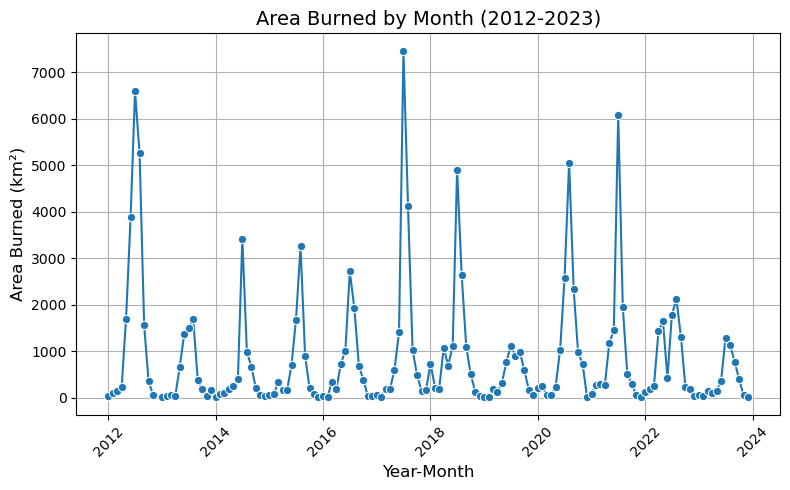

In [18]:
# Create a new column for 'year-month'
events_west['ig_date'] = pd.to_datetime(events_west['ig_date'])
events_west['year_month'] = events_west['ig_date'].dt.to_period('M')
# Aggregate the total area burned ('tot_ar_km2') by 'year_month'
monthly_area_burned = events_west.groupby('year_month')['tot_ar_km2'].sum().reset_index()
# Convert 'year_month' back to a datetime format for plotting
monthly_area_burned['year_month'] = monthly_area_burned['year_month'].dt.to_timestamp()

# Plotting the time-series
plt.figure(figsize=(8, 5))
sns.lineplot(x='year_month', y='tot_ar_km2', data=monthly_area_burned, marker='o')
plt.title('Area Burned by Month (2012-2023)', fontsize=14)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Area Burned (km²)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

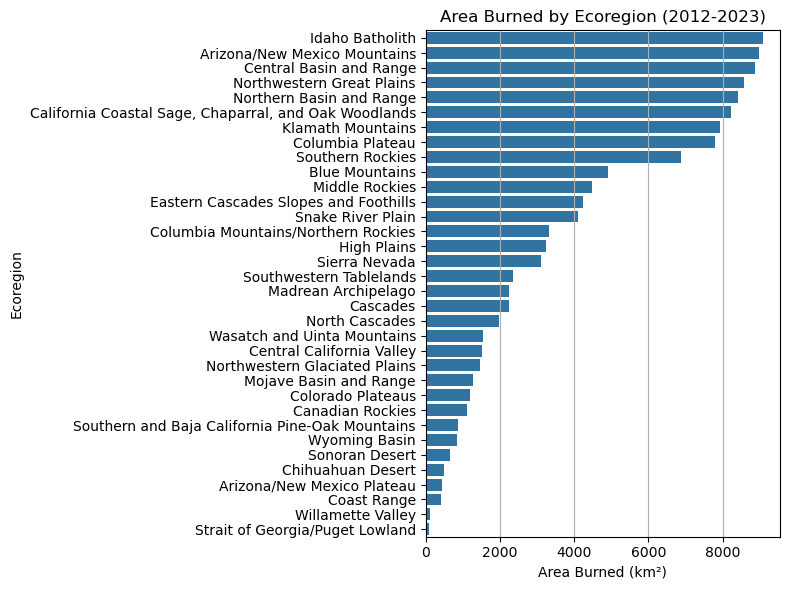

In [17]:
# Aggregate total burned area by ecoregion
eco_burned_area = events_west.groupby('na_l3name')['tot_ar_km2'].sum().reset_index()

# Sort the data by total burned area in descending order
eco_burned_area = eco_burned_area.sort_values(by='tot_ar_km2', ascending=False)

# Plot the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='tot_ar_km2', y='na_l3name', data=eco_burned_area)
plt.title('Area Burned by Ecoregion (2012-2023)', fontsize=12)
plt.xlabel('Area Burned (km²)', fontsize=10)
plt.ylabel('Ecoregion', fontsize=10)
plt.grid(True, axis='x')
plt.tight_layout()

# Show the plot
plt.show()

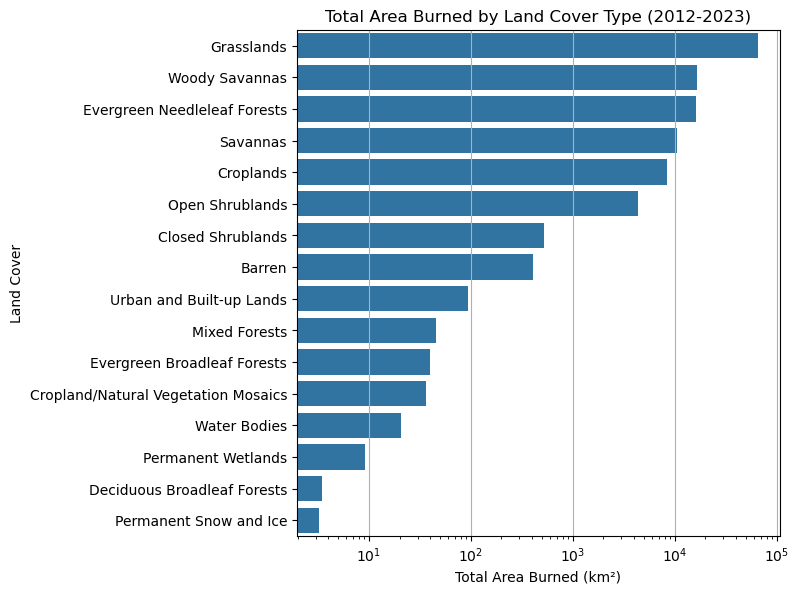

In [15]:
# Aggregate total burned area by ecoregion
lc_burned_area = events_west.groupby('lc_name')['tot_ar_km2'].sum().reset_index()
# Sort the data by total burned area in descending order
lc_burned_area = lc_burned_area.sort_values(by='tot_ar_km2', ascending=False)

# Plot the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='tot_ar_km2', y='lc_name', data=lc_burned_area)
plt.title('Area Burned by Modal Land Cover Type (2012-2023)', fontsize=12)
plt.xlabel('Area Burned (km²)', fontsize=10)
plt.ylabel('Land Cover', fontsize=10)
plt.grid(True, axis='x')
plt.tight_layout()

plt.xscale('log')

# Show the plot
plt.show()

In [19]:
gc.collect()

15063